<h2><center>2D Advection for Lighttransport in Vacuum</center></h2>

This notebook explores the numerical solution of the isotropic $P_1$ Approximation when using a Delta distribution as closure (see survey chapter 2.1.2) in 2-dimensional domain. We will first place a unit point light at the center of the domain and compare the solution against groundtruth results. After some discussion, additional experiments are carried out at the end of the notebook.


---------------------------
Consider the classical diffusion equation without the absorption term (due to vacuum):

$$\nabla(D\nabla\phi)= -q$$

Now if the diffusion coefficient $D$ depends on the unknown variable $\phi$, the diffusion equation _is also_ an advection equation. In case of vacuum (free streaming limit) we have $D=\phi/\lVert \nabla\phi \rVert$ and therefore get the following advection equation:

$$\nabla\left (\frac{\phi}{\lVert \nabla\phi \rVert}\nabla\phi \right )= -q$$

Note that this is different to an advection-diffusion equation, which has seperate terms for advection and diffusion respectively.

---------------------------
The advection equation is discretized using central differences. In particular $\nabla\phi$ is discretized at the voxel faces using central differences. The diffusion coefficient is also discretized at the voxel faces by averaging the diffusion coefficient values of adjacent voxels ($D_{i+\frac{1}{2}}=\frac{1}{2}(D_{i+1}+D_i)$). Those values at the voxel faces are then used to discretize $\nabla(D\nabla\phi)$ with central differences again. We use dirichlet boundary conditions and solve the equation with a simple Gauss-Seidel scheme. 

After a lengthy set of equation transformations, we arrive at the following iterative update rule for $\phi$, where $h$ is the voxelsize:

$$\phi_{ij}^{\prime} = \frac{\frac{1}{h}D_{i-\frac{1}{2}}\phi_{i-1, j}+\frac{1}{h}D_{j-\frac{1}{2}}\phi_{i, j-1}+\frac{1}{h}D_{j+\frac{1}{2}}\phi_{i, j+1}+\frac{1}{h}D_{i+\frac{1}{2}}\phi_{i+1, j}+hq_{ij}}{\frac{1}{h}\left(D_{i+\frac{1}{2}}+D_{i-\frac{1}{2}}+D_{j+\frac{1}{2}}+D_{j-\frac{1}{2}}\right)}$$

---------------------------

For groundtruth comparisons, we use the analytical solution of the fluence from a point light.  In two dimensions, the fluence $\phi$ at distance $r$ away from the location of a unit power point light is given by:

$$\phi(r) = \frac{1}{2\pi r}$$

----------------------------
- **Notes**
    - It is interesting to realize, that the advection equation can be considered a special case of the diffusion equation where the diffusion coefficient depends on the unknown variable.
    - Instead of using a non-linear advection equation, it may be also possible to use an advection-diffusion equation. Such an approach has been explored in [Fast Global Illumination for Volume Visualization](http://vis.cs.ucdavis.edu/papers/zhang_ma_i3d_2013.pdf). However, the theoretical connection to the radiative transfer equation remains to be derived for their approach. Maybe this could be done by exploiting some of the [divergence operator properties](https://en.wikipedia.org/wiki/Divergence#Properties). Their result video looks promising ([see source material](http://dl.acm.org/citation.cfm?id=2448205))
    - Methods for solving advection equations
        - Standard Differencing scheme (Foster and Metaxas)
        - Upwind Scheme (used in Fast Global Illumination for Volume Visualization)
        - Semi-lagrange Advection (Stams stable fluids)
    - Are there connections to Wave Equation/Maxwell Equations?


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
#from math import *
from util import *
import solver as solver

In the following cell we will setup the simulation domain and define a function which runs the Gauss-Seidel solver. The boundary grids are given as arguments and are used during the iteration step to update the boundary cells of the solution (as seen in the C++ code of the iterate2d function below).

In [2]:
# setup domain ---
res = 161
size = 1.0
numIterations = 20500
domain = Domain(size, res)


def run_sim( domain, numIterations, Q, phi_boundary, D_boundary = None ):
    # setup/reset grids ---
    phi = np.zeros((domain.res, domain.res)) # scalar field for which we want to solve 
    D = np.zeros((domain.res, domain.res)) # diffusion coefficients
    if D_boundary is None:
        D_boundary = np.zeros((domain.res, domain.res)) # D boundary values for dirichlet boundary condition 

    # solve ---
    for step in range(numIterations):
        # call inner loop in c++
        solver.iterate_2d(phi, D, Q, phi_boundary, D_boundary, domain.h)
        
    return phi

Due to performance reasons, the inner loop of our Gauss-Seidel solver has been implemented in c++ and been has been exposed to python using [pybind11](https://github.com/pybind/pybind11). Here is the C++ source code of the iterate_2d function:

```cpp
void iterate_2d(py::array_t<double> phi_array, // phi grid (read/write)
                py::array_t<double> D_array, // diffusion coefficient grid (read/write)
                py::array_t<double> Q_array, // grid of emission values (read only)
                py::array_t<double> phi_boundary_array, // boundary values for phi (read only)
                py::array_t<double> D_boundary_array, // boundary values for D (read only)
                double h // voxelsize (in x and y)
                )
{
	py::buffer_info phi_array_info = phi_array.request();
	py::buffer_info D_array_info = D_array.request();
	py::buffer_info Q_array_info = Q_array.request();
	py::buffer_info phi_boundary_array_info = phi_boundary_array.request();
	py::buffer_info D_boundary_array_info = D_boundary_array.request();

	auto phi = static_cast<double *>(phi_array_info.ptr);
	auto D = static_cast<double *>(D_array_info.ptr);
	auto Q = static_cast<double *>(Q_array_info.ptr);
	auto phi_boundary = static_cast<double *>(phi_boundary_array_info.ptr);
	auto D_boundary = static_cast<double *>(D_boundary_array_info.ptr);

	int res_y = phi_array_info.shape[0];
	int res_x = phi_array_info.shape[1];

	// update boundary conditions ---
	// here we copy over just the ghost cell values from the boundary grids
	for (int i = 0; i < res_y; ++i)
	{
		int idx_0 = index_2d(i, 0, res_x);
		int idx_1 = index_2d(i, res_x - 1, res_x);
		phi[idx_0] = phi_boundary[idx_0];
		phi[idx_1] = phi_boundary[idx_1];
		D[idx_0] = D_boundary[idx_0];
		D[idx_1] = D_boundary[idx_1];
	}
	for (int i = 0; i < res_x; ++i)
	{
		int idx_0 = index_2d(0, i, res_x);
		int idx_1 = index_2d(res_y - 1, i, res_x);
		phi[idx_0] = phi_boundary[idx_0];
		phi[idx_1] = phi_boundary[idx_1];
		D[idx_0] = D_boundary[idx_0];
		D[idx_1] = D_boundary[idx_1];
	}

	// now iterate over all inner cells and update phi and D
	for (int i=1; i < res_y-1; ++i)
		for (int j=1; j < res_x-1; ++j)
		{
			int idx = index_2d(i, j, res_x);
			int idx_xp = index_2d(i, j+1, res_x);
			int idx_xm = index_2d(i, j-1, res_x);
			int idx_yp = index_2d(i-1, j, res_x);
			int idx_ym = index_2d(i+1, j, res_x);

			// compute phi gradient at cell center-- -
			V2d grad_phi;
			grad_phi[0] = (phi[idx_xp] - phi[idx_xm]) / (2.0*h);
			grad_phi[1] = (phi[idx_yp] - phi[idx_ym]) / (2.0*h);

			// Here is where we need to handle the case where D becomes zero.
            // This would cause a division by zero during update of phi.
			// NB: the threshold value for phi has an effect on the accuracy
            // of the solution. It has been hand-picked for the pointsource test.
			double dc = std::max(phi[idx], 0.0004) / std::max(grad_phi.norm(), 1.0e-4);

			// compute diffusion coefficients at cell faces-- -
			double D_xph = (dc + D[idx_xp])*0.5;
			double D_xmh = (dc + D[idx_xm])*0.5;
			double D_yph = (dc + D[idx_yp])*0.5;
			double D_ymh = (dc + D[idx_ym])*0.5;

			double numerator = 0.0;
			numerator += D_xph*phi[idx_xp];
			numerator += D_xmh*phi[idx_xm];
			numerator += D_yph*phi[idx_yp];
			numerator += D_ymh*phi[idx_ym];
			numerator /= h;
			numerator += h*Q[idx];

			double denominator = 0.0;
			denominator += (D_xph + D_xmh + D_yph + D_ymh) /h;

			phi[idx] = numerator / denominator;
			D[idx] = dc;
		}
}
``` 

## Experiment: Single Pointlight in Vacuum
----------------------------------------------

In the following cell, we discretize the pointlight at the domain center into the emission field and run the simulation. We distribute the unit power of the point light over the voxel area (2d) which explains the $1/(h^2)$ factor.

In [3]:
# SCENE: single pointlight -----------------------------------------------

# initialize emission field ---
Q = np.zeros((domain.res, domain.res))
pointlight1_center_ls = np.array([0.5, 0.5])
pointlight1_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight1_center_ls))
Q[ pointlight1_voxel[0], pointlight1_voxel[1] ] = 1.0/(domain.h*domain.h)

# compute groundtruth results for validation and boundary conditions ---
phi_groundtruth = domain.rasterize( lambda pWS: pointsource_2d_fluence(pWS, domain.localToWorld(pointlight1_center_ls)) )
gradphi_groundtruth = domain.gradient(phi_groundtruth)
def compute_D( phi, gradphi ):
	''' this function computes the diffusion coefficient from given phi and phi gradient values'''
	l = np.linalg.norm(gradphi)
	if l>0.0:
		return phi/l
	return 0.0
D_groundtruth = domain.rasterizeVS( lambda i,j:compute_D(phi_groundtruth[i,j], gradphi_groundtruth[i,j]) )

# initialize boundary values from groundtruth results ---
# we do this to see the solution without any boundary effects
D_boundary = np.copy(D_groundtruth)
phi_boundary = np.copy(phi_groundtruth)

# run simuation ---
phi = run_sim( domain, numIterations, Q, phi_boundary, D_boundary)

In the following cell we plot the solution (dotted green) against the groundtruth analytical result for a point light in vacuum in 2d domain (green line).

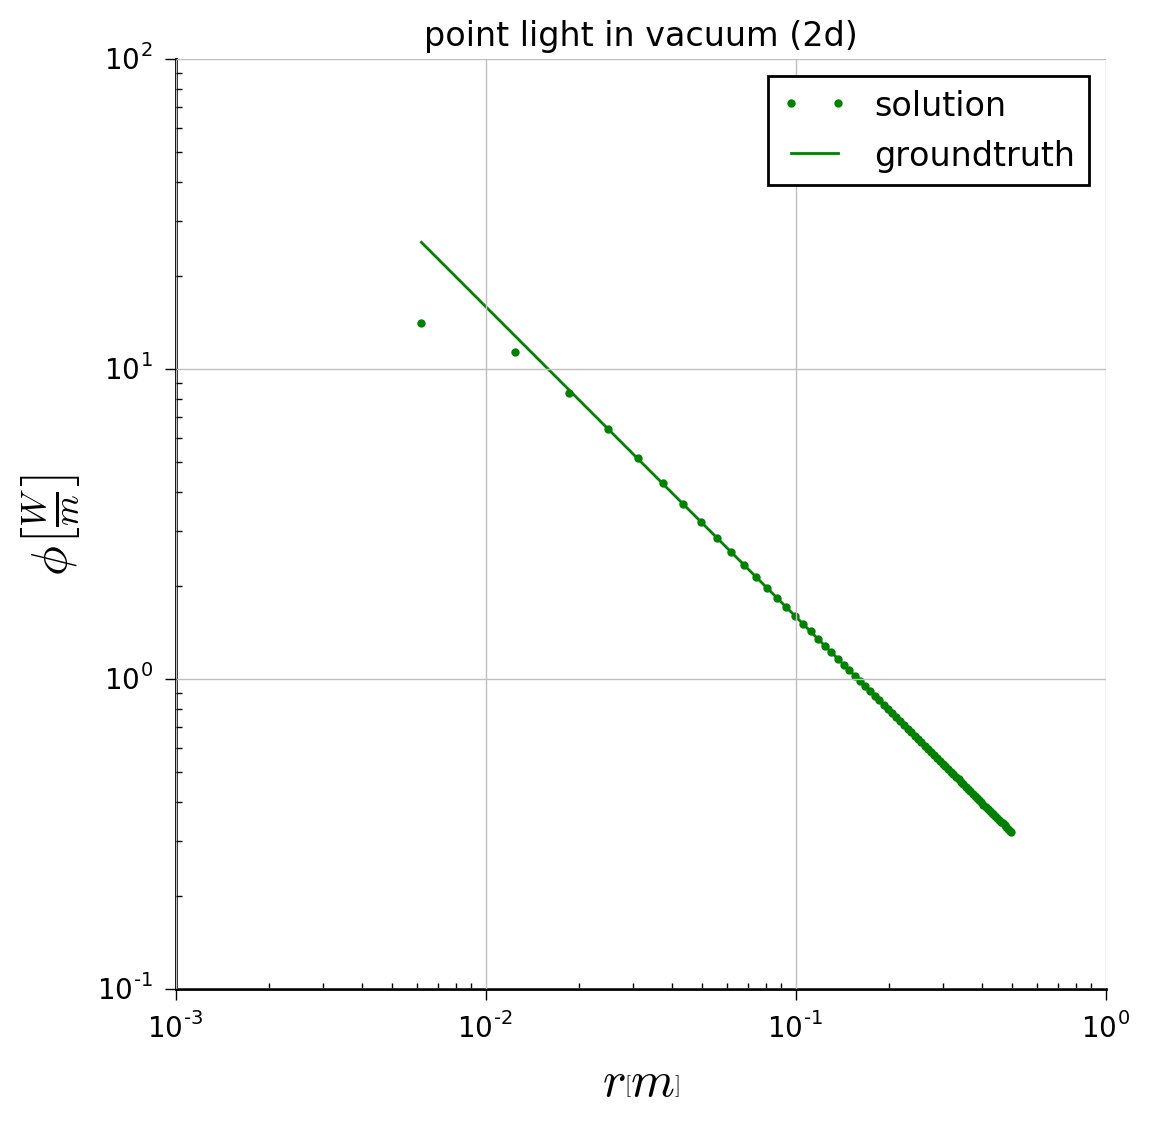

In [4]:
# plot 1d slice at horizontal center line ------------------------------------------------
center_voxel = domain.voxelToIndex(domain.worldToVoxel(domain.localToWorld(np.array([0.5, 0.5]))))
domain_x = domain.rasterize( lambda pWS: pWS[0] )

plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi[center_voxel[0], center_voxel[1]:], label="solution", color = 'g', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi_groundtruth[center_voxel[0], center_voxel[1]:], label="groundtruth", color = 'g' )
plt.title("point light in vacuum (2d)")
plt.xlabel(r'$r \left[m\right]$', fontsize=18)
plt.ylabel(r'$\phi \left[\frac{W}{m}\right]$', fontsize=18)
plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')
plt.draw()
plt.show()

### Discussion

- **Results**
    - We see that the numerical solution matches the groundtruth very well. Only near the origin the solution starts to deviate. This error comes from the point light discretization. Increasing the resolution would decrease the voxelsize and improve the point light discretization which would decrease this error.
    - It is quite remarkable that we can take the diffusion equation, which only works in very dense media and apply it to a vacuum problem which does not contain any participating media at all. By changing the diffusion coefficient, we can still solve the equation and get a useful result. This concept is somehow burried within the complexity of flux-limited diffusion and the variable eddington factor formalism.
    - In our current result we see no boundary effects in our solution. This is because we initialized the boundary conditions to the correct solution. In a more practical scenario, the groundtruth solution would not be available and a choice of e.g. $\phi=0$ at the boundary would cause some visible effects in regions near the boundary.
    - Another importans aspect is the use of thresholding when computing the diffusion coefficent in the inner loop (see C++ code above at 'double dc = ...' ). We can not allow the value of phi or its gradient length to be zero, because this would cause a division by zero when updating $\phi_{ij}$. This problem is addressed by enforcing a minimum value on phi and its gradient length. The threshold of this minimum value has some subtle effects on the accuracy of the solution. The currently used values of $4.0e^{-1}$ and $1.0e^{-1}$ have been hand-picked to get the best possible result.
    

## Experiment: Two Pointlights in Vacuum
----------------------------------------------

Here we discretize two pointslights which are located next to each other into the emission field. We then run the simulation and plot the results including groundtruth solution.

In [5]:
# setup scene and dirichlet boundary conditions for phi ---
Q = np.zeros((domain.res, domain.res))
pointlight1_center_ls = np.array([0.4, 0.5])
pointlight2_center_ls = np.array([0.6, 0.5])
pointlight1_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight1_center_ls))
pointlight2_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight2_center_ls))
Q[ pointlight1_voxel[0], pointlight1_voxel[1] ] = 1.0/(domain.h*domain.h)
Q[ pointlight2_voxel[0], pointlight2_voxel[1] ] = 1.0/(domain.h*domain.h)
phi_boundary = np.zeros((domain.res, domain.res))

# run simuation ---
phi = run_sim( domain, numIterations, Q, phi_boundary)


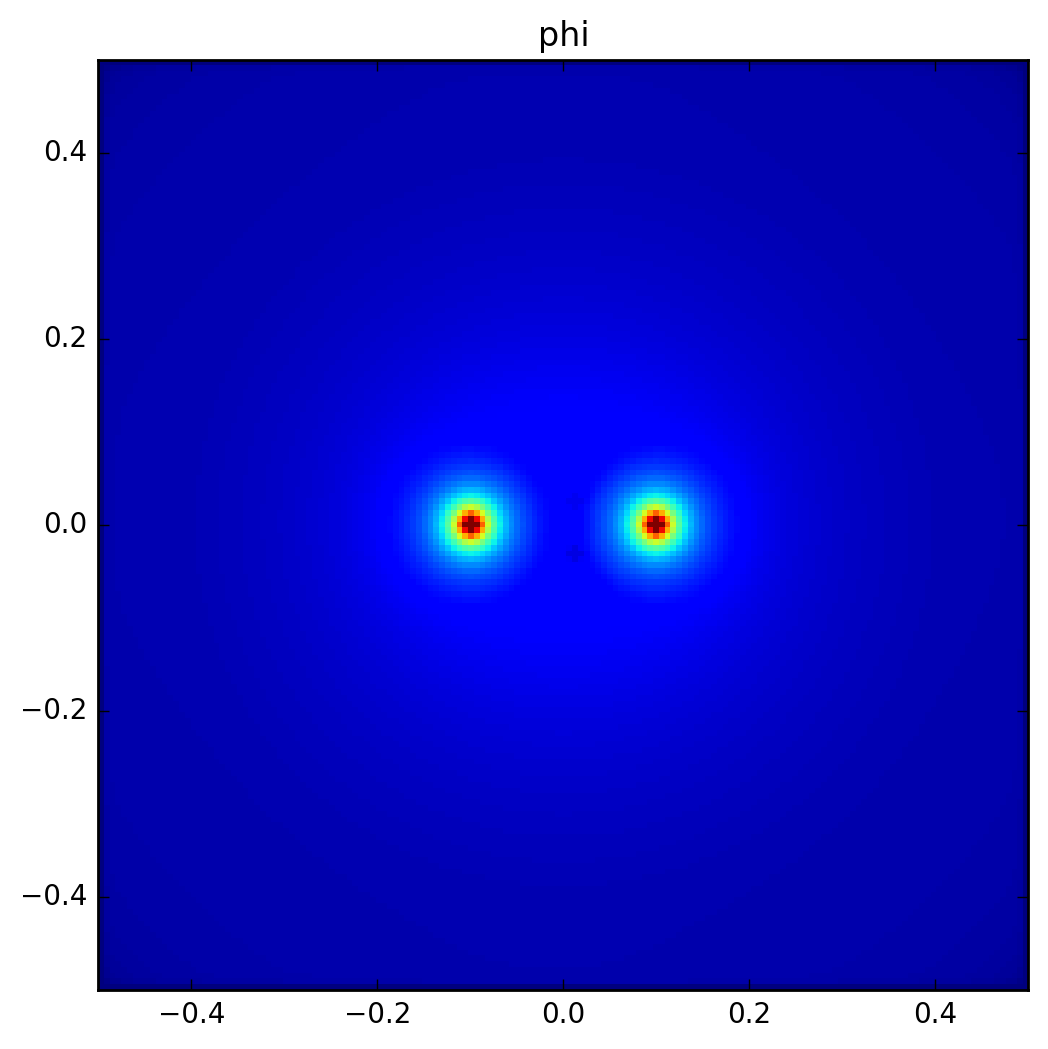

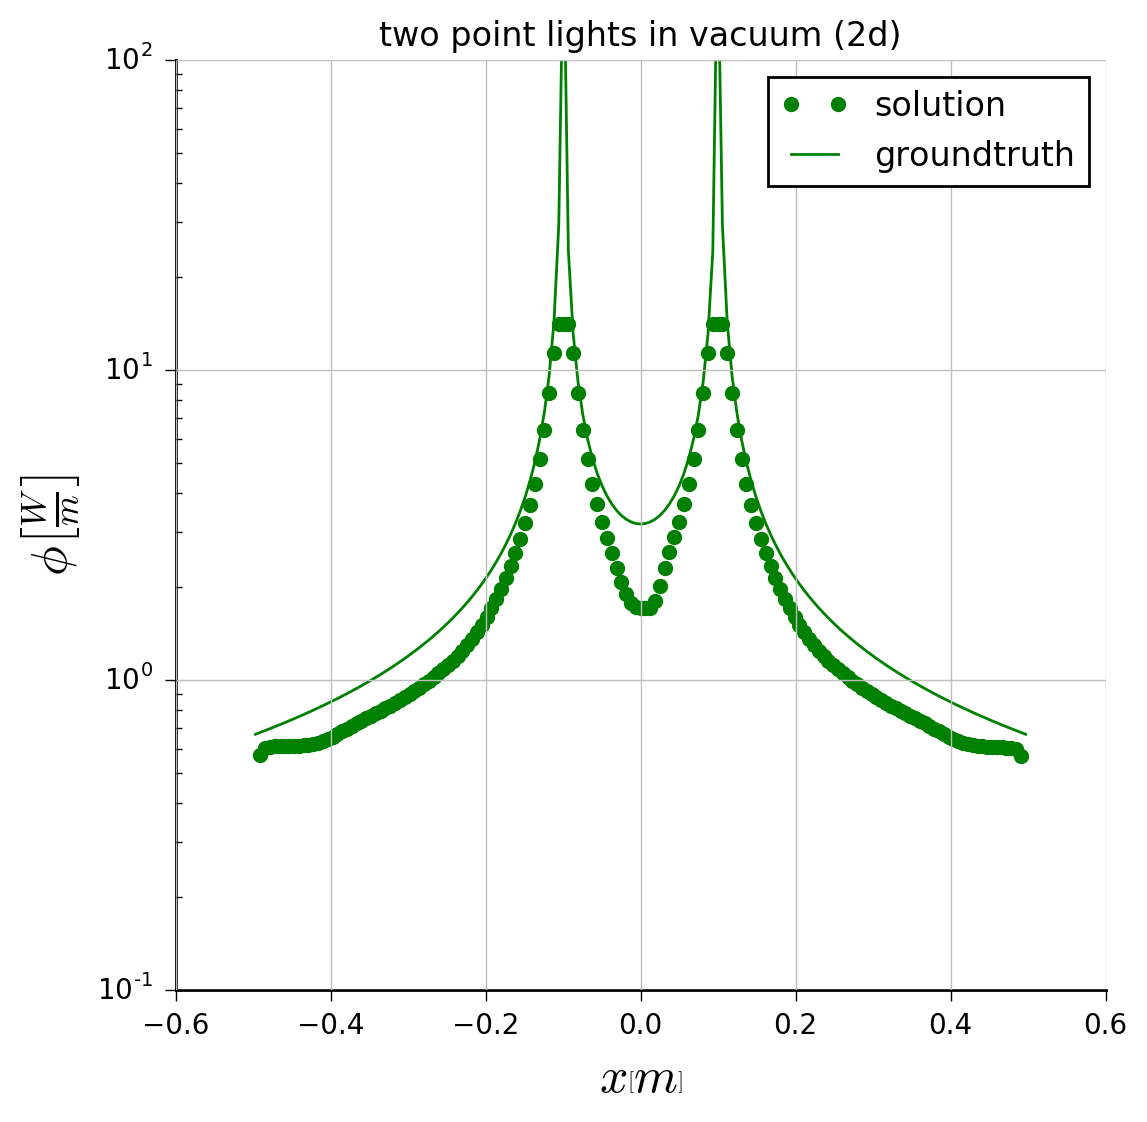

In [6]:
phi_groundtruth = domain.rasterize( lambda pWS: pointsource_2d_fluence(pWS, domain.localToWorld(pointlight1_center_ls)) + pointsource_2d_fluence(pWS, domain.localToWorld(pointlight2_center_ls)) )

# plot phi 2d ---
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('phi')
plt.imshow(phi, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
#plt.imshow(phi_groundtruth, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
plt.show

# plot along horizontal center line ---
domain_x = domain.rasterize( lambda pWS: pWS[0] )
center_voxel = domain.voxelToIndex(domain.worldToVoxel(domain.localToWorld(np.array([0.5, 0.5]))))

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
plt.semilogy( domain_x[center_voxel[0], :], phi[center_voxel[0], :], label="solution", color = 'g', linestyle=' ', marker='.', markersize=10 )
plt.semilogy( domain_x[center_voxel[0], :], phi_groundtruth[center_voxel[0], :], label="groundtruth", color = 'g' )
plt.title("two point lights in vacuum (2d)")
plt.xlabel(r'$x \left[m\right]$', fontsize=18)
plt.ylabel(r'$\phi \left[\frac{W}{m}\right]$', fontsize=18)
plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')
plt.draw()
plt.show()

### Discussion

- We see that the numerical solution now deviates from the groundtruth much more than for the single pointlight solution. The reason for that is that in real lighttransport, fluence is simply added for each pointlight and this does not happen when solving our PDE approximation. The issue becomes more apparent with the next example.
- We also see some minor effects at the boundary because we didn't initialize the boundary cells to the correct solution.

## Experiment: Pointlight and Directionallight in Vacuum
----------------------------------------------

Here we discretize a single pointlight and a directional light source. The directional lightsource is modelled through high values for $\phi$ at the boundary voxels. This causes some influx at the faces between boundary voxels and inner voxels. We then run the simulation and plot the results. Since the directional light source is modelled in a hacky way, groundtruth solutions are not available here.

In [7]:
# setup scene and dirichlet boundary conditions for phi ---
Q = np.zeros((domain.res, domain.res))
pointlight1_center_ls = np.array([0.5, 0.5])
pointlight1_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight1_center_ls))
Q[ pointlight1_voxel[0], pointlight1_voxel[1] ] = 1.0/(domain.h*domain.h)
phi_boundary = np.zeros((domain.res, domain.res))

# hacky directional light source
for i in range(domain.res):
    phi_boundary[i, domain.res-1] = 10.0

# run simuation ---
phi = run_sim( domain, numIterations, Q, phi_boundary)


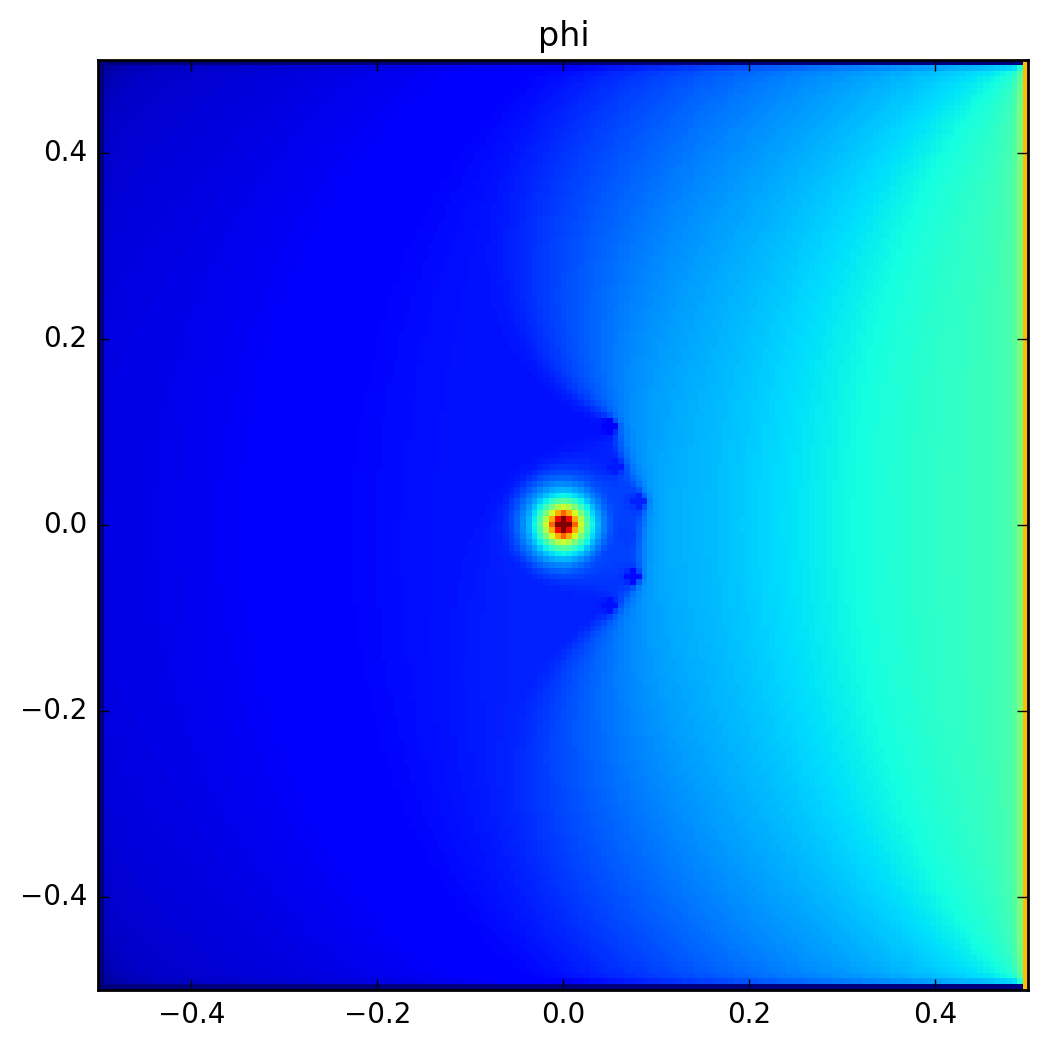

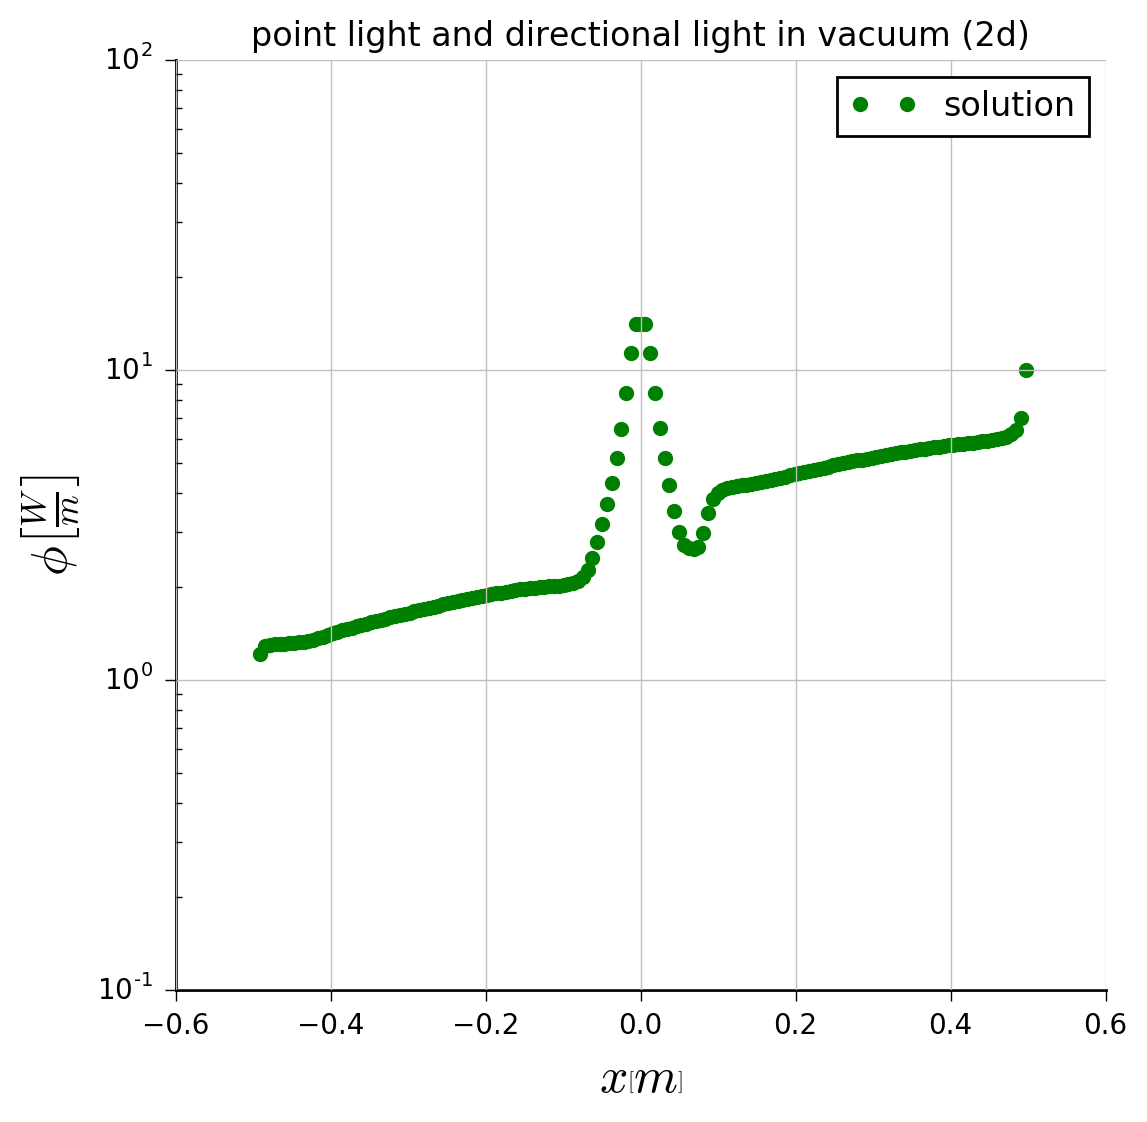

In [8]:
# plot phi 2d ---
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title('phi')
plt.imshow(phi, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
plt.show()

# plot along horizontal center line ----------
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
plt.semilogy( domain_x[center_voxel[0], :], phi[center_voxel[0], :], label="solution", color = 'g', linestyle=' ', marker='.', markersize=10 )
plt.title("point light and directional light in vacuum (2d)")
plt.xlabel(r'$x \left[m\right]$', fontsize=18)
plt.ylabel(r'$\phi \left[\frac{W}{m}\right]$', fontsize=18)
plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')
plt.draw()
plt.show()

### Discussion

- Similar to the result for two pointlights, we see that fluence from different light sources does not add up. It is more the case that every lightsource causes its own wavefront and when wavefronts from different light sources meet, the solver kind of blends them together locally.